# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import cm
from plotly import express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def data_summary(num_attributes):
    # Central tendency - mean, median
    tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    tc2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Variability - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(min)).T
    d2 = pd.DataFrame(num_attributes.apply(max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concatenate
    s = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
    s.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return s

In [4]:
def eval_wss(x, clusters, random_state=73):
    wss = []
    for k in clusters:
        model = KMeans(init = 'random',
                       n_clusters = k,
                       max_iter = 300,
                       random_state = random_state)
        model.fit(x)
        wss.append(model.inertia_)
    return wss

def eval_ss(x, clusters, random_state=73):
    ss = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=random_state)
        pred = model.fit_predict(x)
        score = silhouette_score(x, pred, metric='euclidean')
        ss.append(score)
    return ss

## Importar dados

In [63]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')
df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [64]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [65]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [19]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [20]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tratar os NAs

In [21]:
df1['description'].fillna('-', inplace = True)
df1.dropna(inplace = True)

In [22]:
print('Dados removidos: {:.1f}%'.format(100*(1-df1.shape[0]/df_raw.shape[0])))
print('Número de linhas: {}'.format(df1.shape[0]))

Dados removidos: 24.9%
Número de linhas: 406829


In [23]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.4 Tipo dos dados

In [24]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype(int)

In [25]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.5 Estatística descritiva

In [26]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'description', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [27]:
data_summary(num_attributes)

,columns,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


### 1.5.2 Atributos categóricos

In [59]:
cat_attributes.apply(lambda x: x.nunique())

invoice        22190
stock_code      3684
description     3896
customer_id     4372
country           37
dtype: int64

In [60]:
df1[df1['invoice'].apply(lambda x: bool(re.search('[a-zA-Z]', x)))].head()

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


# 2 Filtragem das variáveis

## Data checkpoint

In [52]:
df2 = df1.copy()

In [19]:
df2.to_csv('../data/interim/c2_df2.csv', index = False)

In [84]:
df2 = pd.read_csv('../data/interim/c2_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Stock code

In [85]:
size_of_data = len(df2)

In [86]:
df2.loc[df2['stock_code'].apply(lambda x: x.isalpha()), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [87]:
# Remover stock code M, POST, PADS, DOT, CRUK
bad_description = ['M', 'POST', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(bad_description)]

## 2.2 Description

In [88]:
df2.loc[df2['description'].apply(lambda x: x.isalpha()), 'description'].unique()

array(['Discount', 'CARRIAGE'], dtype=object)

In [89]:
# Remover description CARRIAGE
df2 = df2[df2['description'] != 'CARRIAGE']

## 2.3 Customer id

In [90]:
# Clientes cujos id só possuem mais registros de devolução do que compra.
bad_customers = [12605, 12666, 12870, 12943, 13693, 
                 13829, 13958, 14119, 14213, 14627, 
                 14679, 14777, 15638, 15728, 16061, 
                 16138, 16252, 16262, 16428, 16579, 
                 16742, 16995, 17307, 17547, 17820, 
                 18141, 18256, 15823, 17548, 16546]
df2 = df2[~df2['customer_id'].isin(bad_customers)]

## 2.4 Dados filtrados

In [91]:
print('Dados removidos: {:.1f}%'.format(100*(1-df2.shape[0]/size_of_data)))
print('Número de linhas: {}'.format(df2.shape[0]))

Dados removidos: 0.5%
Número de linhas: 404850


# 3 Feature engineering

## Data checkpoint

In [92]:
df3 = df2.copy()

In [93]:
df3.to_csv('../data/interim/c2_df3.csv', index = False)

In [72]:
df3 = pd.read_csv('../data/interim/c2_df3.csv')
df3['invoice_date'] = pd.to_datetime(df3['invoice_date'])

## 3.1 Criação das variáveis

**customer_id:** customer identification

**revenue:** total amount spend by customer so far

**invoices:** number of purchases

**mean_ticket:** average expense of a customer per invoice

**recency:** time since last purchase

**mean_recency:** average interval between purchases

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**returns:** number of purchases where at least one product was returned

**mean_basket_size:** average number of items per purchase

**country:** customer's country of residence

In [94]:
# Revenue
df3['price'] = df3['quantity']*df3['unit_price']
df_customer = df3[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'revenue'})

# invoices - number of purchases
aux1 = df3[~df3['invoice'].str.startswith('C')]
aux2 = aux1[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices'})
df_customer = df_customer.merge(aux2, how = 'left', on = 'customer_id')

# mean_ticket
df_customer['mean_ticket'] = df_customer['revenue']/df_customer['invoices']

# last invoice date
aux = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns = {'invoice_date': 'last_date'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# recency - days since last purchase
ref_date = df_customer['last_date'].max()
df_customer['recency'] = df_customer['last_date'].apply(lambda x: (ref_date-x).days)

# # mean_recency

# low_purch
# aux = df3[['customer_id', 'invoice', 'price']].groupby(['customer_id', 'invoice']).sum().reset_index()
# df_low = aux.groupby('customer_id').min().reset_index()
# df21['low_purch'] = df_low['price']

# # high_purch
# df_high = aux.groupby('customer_id').max().reset_index()
# df21['high_purch'] = df_high['price']

# # returns

# # mean_basket_size

# # country


In [95]:
df_customer.isna().sum()

customer_id    0
revenue        0
invoices       0
mean_ticket    0
last_date      0
recency        0
dtype: int64

In [96]:
df3 = df_customer.drop(columns = 'last_date').copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [97]:
df4 = df3.copy()

In [12]:
df4.to_csv('../data/interim/c1_df4.csv', index = False)

In [30]:
df4 = pd.read_csv('../data/interim/c1_df4.csv')

## 4.1 Análise univariada

### 4.1.1 Variáveis numéricas

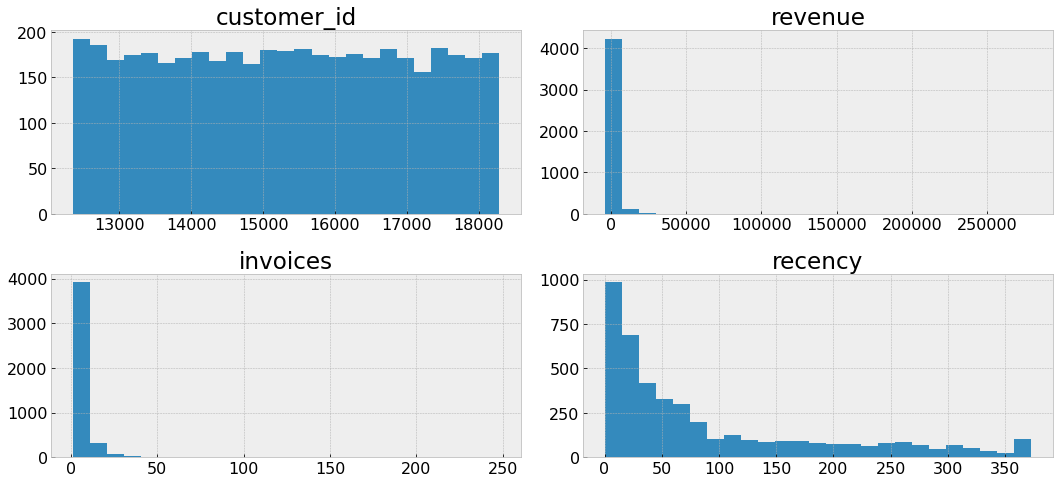

In [31]:
df4.hist(bins = 25);
plt.tight_layout()

<AxesSubplot:ylabel='recency'>

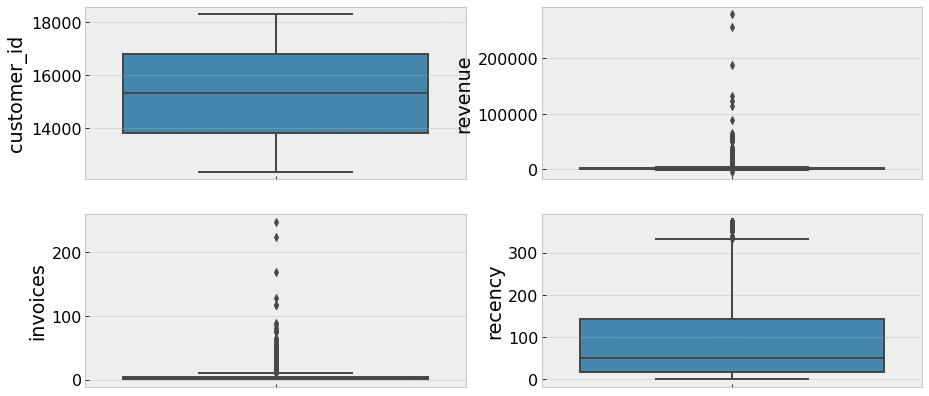

In [34]:
plt.subplot(2,2,1)
sns.boxplot(data = df4, y = 'customer_id')

plt.subplot(2,2,2)
sns.boxplot(data = df4, y = 'revenue')

plt.subplot(2,2,3)
sns.boxplot(data = df4, y = 'invoices')

plt.subplot(2,2,4)
sns.boxplot(data = df4, y = 'recency')

## 4.2 Modelo RFM

In [35]:
df42 = df4.copy()

In [36]:
df42 = df42.sort_values('revenue', ascending = False).reset_index(drop = True)
df42['m_score'] = 5-4*df42.index/len(df42)

df42 = df42.sort_values('recency').reset_index(drop = True)
df42['r_score'] = 5-4*df42.index/len(df42)

df42 = df42.sort_values('invoices', ascending = False).reset_index(drop = True)
df42['f_score'] = 5-4*df42.index/len(df42)

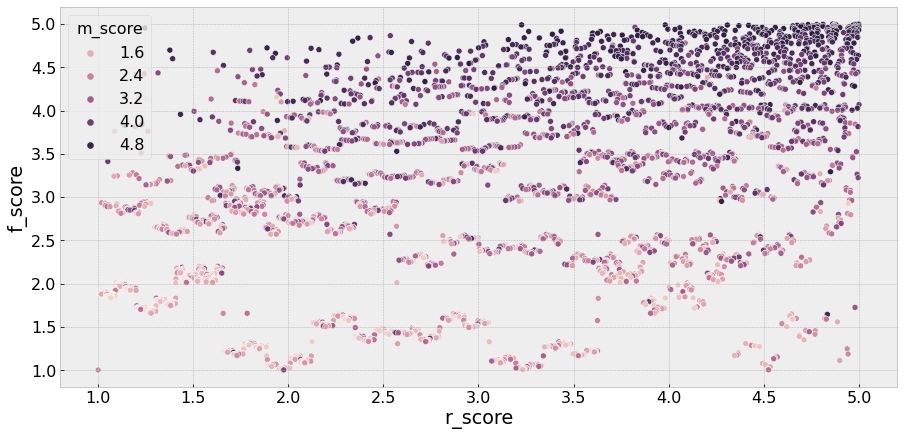

In [37]:
sns.scatterplot(data = df42, x = 'r_score', y = 'f_score', hue = 'm_score');

In [38]:
inside = df42[(df42['r_score'] > 4.5) & (df42['f_score'] > 4.5)]
inside.head()

,customer_id,revenue,invoices,recency,m_score,r_score,f_score
0,14911.0,132572.62,248,1,4.997255,4.861817,5.000000
1,12748.0,29072.10,224,0,4.976207,4.997255,4.999085
2,17841.0,40340.78,169,1,4.983528,4.875543,4.998170
3,14606.0,11713.85,128,1,4.932281,4.877374,4.997255
4,13089.0,57385.88,118,2,4.990849,4.810570,4.996340


In [39]:
inside.shape

(223, 7)

In [44]:
inside['revenue'].sum()

2791514.95

# 5 Preparação dos dados

In [98]:
df5 = df4.copy()

# 6 Seleção das features

In [99]:
df6 = df5.copy()

# 7 Ajuste fino dos hyperparâmetros

## Data checkpoint

In [100]:
df7 = df6.copy()
X = df7.drop('customer_id', axis = 1)

In [101]:
df7.to_csv('../data/interim/c2_df7.csv', index = False)

In [35]:
df7 = pd.read_csv('../data/interim/c1_df7.csv')
X = df7.drop('customer_id', axis = 1)

## 7.1 Within-Cluster Sum of Square

In [104]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

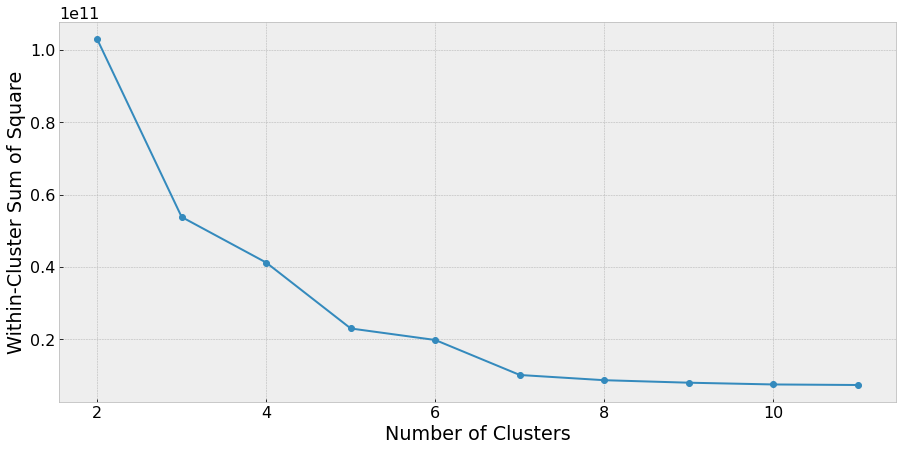

In [105]:
wss = eval_wss(X, clusters)
plt.plot(clusters, wss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square');

## 7.2 Silhouette Score

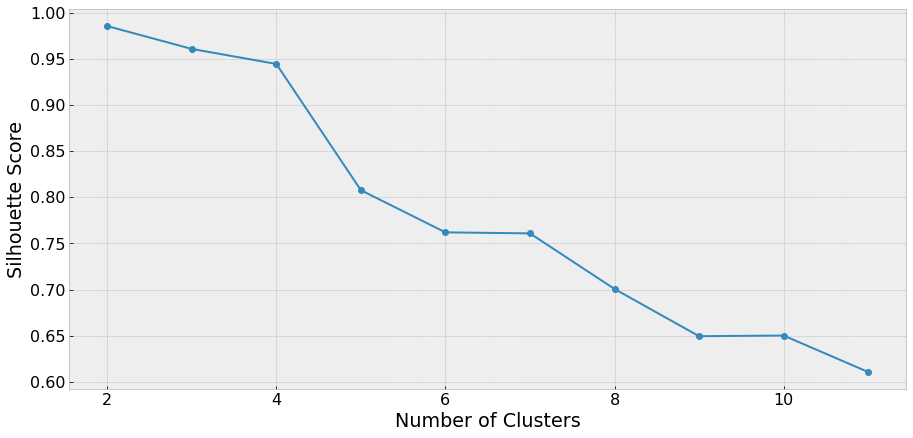

In [106]:
ss = eval_ss(X, clusters)
plt.plot(clusters, ss, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

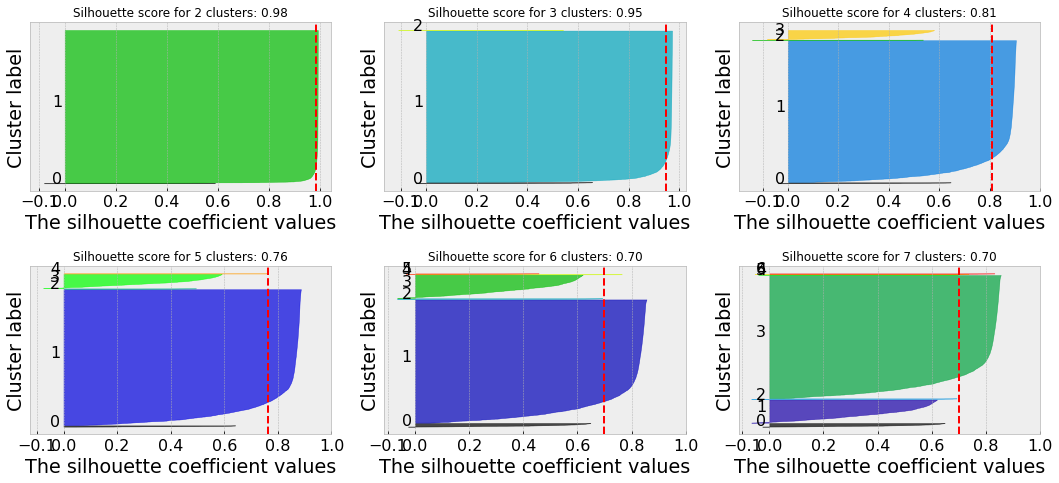

In [107]:
clusters = [2, 3, 4, 5, 6, 7]
grid_cols = 3
fig, axs = plt.subplots(2, grid_cols)
for i in range(len(clusters)):
    n_clusters = clusters[i]
    
    clusterer = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=100, random_state=73)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    r, c = divmod(i, grid_cols)
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        axs[r][c].fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          jth_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[r][c].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axs[r][c].set_xlabel("The silhouette coefficient values")
    axs[r][c].set_ylabel("Cluster label")
    axs[r][c].set_title(
        'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
        fontsize = 12
    )

    # The vertical line for average silhouette score of all the values
    axs[r][c].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[r][c].set_yticks([]) # Clear the yaxis labels / ticks
    axs[r][c].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

# 8 Machine learning

## Data checkpoint

In [109]:
df8 = df7.copy()
X = df8.drop('customer_id', axis = 1)

## 8.1 K-means

In [144]:
n_clusters = 3

In [145]:
# Training
kmeans = KMeans(init = 'random',
                n_clusters = n_clusters,
                n_init = 10,
                max_iter = 300,
                random_state = 73)
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

### 8.1.1 Cluster validation

In [146]:
print('WSS: {}'.format(kmeans.inertia_))
print('SS: {}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 53833898228.51181
SS: 0.9483843496479274


# 9 Análise do cluster

In [147]:
df9 = df7.copy()
df9['cluster'] = labels

## 9.1 Inspeção visual

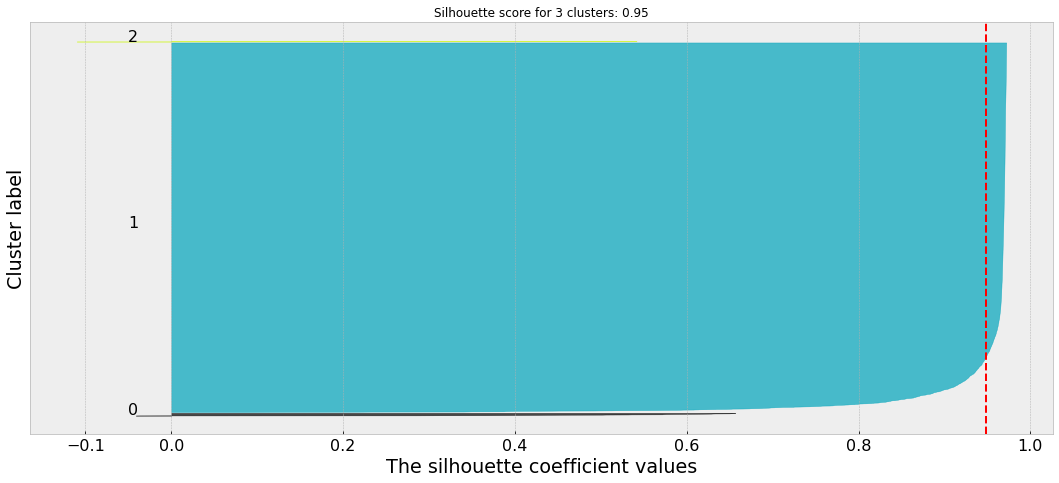

In [148]:
fig, ax = plt.subplots()

cluster_labels = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
r, c = divmod(i, grid_cols)
for j in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster j, and sort them
    jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

    jth_cluster_silhouette_values.sort()

    size_cluster_j = jth_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_j

    color = cm.nipy_spectral(float(j) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      jth_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title(
    'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
    fontsize = 12
)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([]) # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

### 9.1.1 3 features

fig = px.scatter_3d(df9, x = 'recency', y = 'invoices', z = 'revenue', color = 'cluster')
fig.show()

### 9.1.2 More than 3 features

In [149]:
df_plot = df9.drop(columns = 'customer_id')

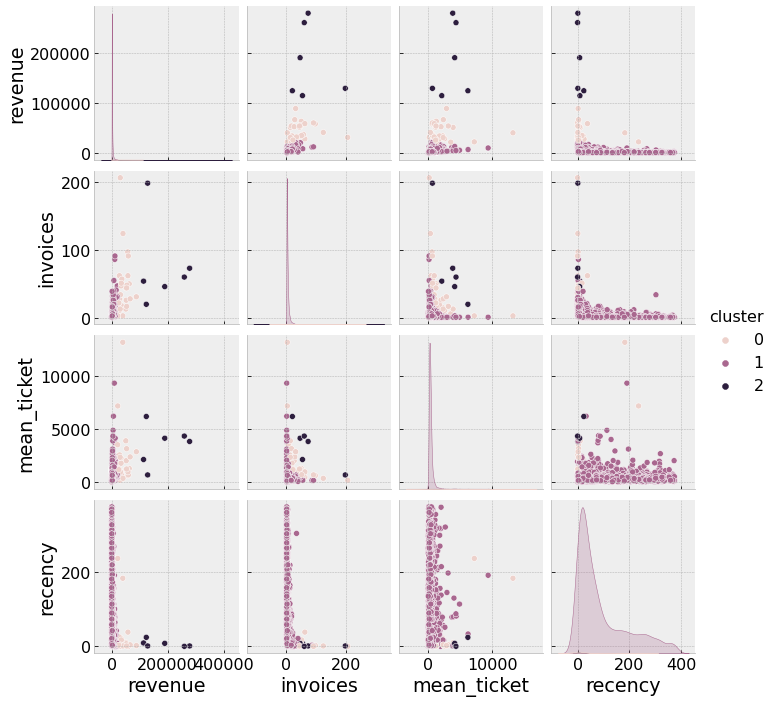

In [150]:
sns.pairplot(df_plot, hue = 'cluster')

## 9.2 Descrição do perfil

In [151]:
# Número de clientes
df_cluster = df9[['cluster', 'customer_id']].groupby('cluster').count().reset_index()
df_cluster['customer%'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Receita média
aux = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Recência média
aux = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Número de compras médio
aux = df9[['cluster', 'invoices']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Média do ticket médio
aux = df9[['cluster', 'mean_ticket']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

df_cluster

,cluster,customer_id,customer%,revenue,recency,invoices,mean_ticket
0,0,32,0.738518,40638.048125,18.562500,41.875000,2025.446204
1,1,4295,99.123009,1371.604000,90.857043,3.869849,352.852806
2,2,6,0.138472,182303.461667,7.166667,75.166667,3534.263236


*Cluster 0:*
- Número de clientes: 31 (0,71% da base de clientes)
- Recência média: 13 dias
- Número médio de compras: 53 compras
- Receita média: $40.543,52

*Cluster 1 (candidato ao programa Insider):*
- Número de clientes: 6 (0,14% da base de clientes)
- Recência média: 7 dias
- Número médio de compras: 89 compras
- Receita média: $182.181,98

*Cluster 2:*
- Número de clientes: 4334 (99,15% da base de clientes)
- Recência média: 92 dias
- Número médio de compras: 4 compras
- Receita média: $1.372,89